# Audio Source Seperation using NMF (Non-Negative Matrix Factorization)

* In music seperation we  seperate the different instruments that make up a music.
* In speech seperation, we seperate different speakers in a recording.
* In speech enhancement, we can seperate the vocals and the background noise or song.


## NMF
* The NMF algorithm factorize a given data matrix V into two non-negative unknown matrices W and H, such that the product of the two matrices approximates the original matrix.
* In the context of sound source seperation:
  * The original data matrix V is the time-frequency representation of the audio signal, also known as *spectrogram*.
  * W represents a dictionary of *elementray recurring features*.
  * H contains the activations of the different features.



In [5]:
!wget https://github.com/ZahraBenslimane/SoundSourceSeparation_usingNMF/raw/main/data/piano_mix.wav

--2023-09-20 03:55:36--  https://github.com/ZahraBenslimane/SoundSourceSeparation_usingNMF/raw/main/data/piano_mix.wav
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZahraBenslimane/SoundSourceSeparation_usingNMF/main/data/piano_mix.wav [following]
--2023-09-20 03:55:36--  https://raw.githubusercontent.com/ZahraBenslimane/SoundSourceSeparation_usingNMF/main/data/piano_mix.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308100 (301K) [audio/wav]
Saving to: ‘piano_mix.wav’

piano_mix.wav       100%[===================>] 300.88K  --.-KB/s    in 0.006s  

2023-09-20 03:55:36 (50.5 MB/s) - ‘pian

In [21]:
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math

In [9]:
AUDIO_FILE = 'piano_mix.wav'
SAMPLE_RATE = 5512

In [32]:
ipd.Audio(AUDIO_FILE)

In [13]:
audio_sound, sr = librosa.load(AUDIO_FILE, sr=SAMPLE_RATE)

## Sound Signal Waveform

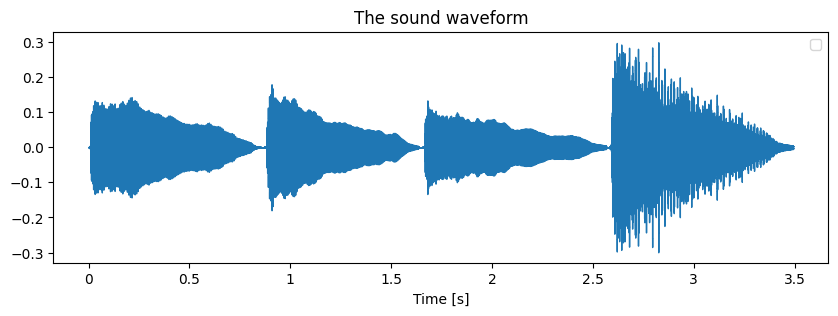

In [16]:
fig, ax = plt.subplots(figsize=(10, 3))
librosa.display.waveshow(audio_sound, sr=sr, ax=ax, axis='time')
ax.set(title="The sound waveform", xlabel='Time [s]')
ax.legend()

The audio consists of 3 consecutive different piano notes followed by the 3 notes played together.

The last picture depicts the mixture of the 3 musical notes.

## Compute the STFT of the signal

* The Short Term Fourier Transform represents the audio signal in terms of complex-valued coefficients which provides the frequency and phase content of local sections of a signal as it evolves over time.

* A spectrogram is a visual representaion of the changing spectra as a function of a time.
  * Each column of a spectrogram represents a time frame of the audio, and each row represents a certain *frequency.*

  * It is a squared magnitude of the STFT.

Text(0.5, 1.0, 'Audio Spectrogram')

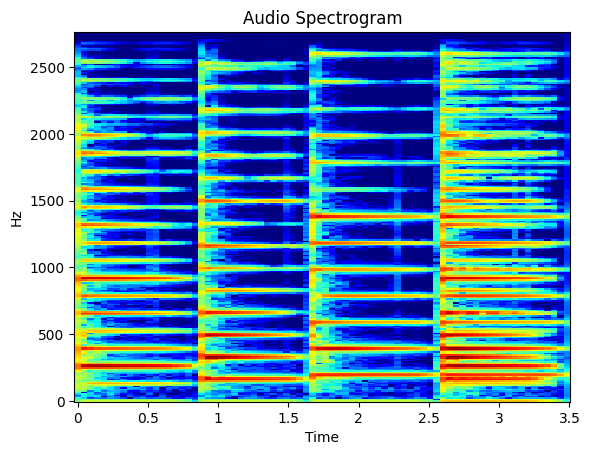

In [22]:
# Complex STFT
sound_stft = librosa.stft(audio_sound, n_fft=512, hop_length=256)

# Magnitude Spectrogram
sound_stft_magnitude = np.abs(sound_stft)

# Phase spectrogram
sound_stft_angle = np.angle(sound_stft)

# Plot spectrogram
spec = librosa.amplitude_to_db(sound_stft_magnitude, ref=np.max)
librosa.display.specshow(spec, y_axis='hz', sr=sr, hop_length=256, x_axis='time', cmap=matplotlib.cm.jet)
plt.title("Audio Spectrogram")

In [34]:
sound_stft_magnitude.shape

(257, 76)

## Applying the Non-Negative Matrix Factorisation

* Randomly Initialize W and H matrices with non-negative values.
* Update W and H, by considering the other fixed.
* Repeat 2 until the convergence threshold is hit.

In [24]:
def divergence(V, W, H, beta=2):
  if beta == 0: return np.sum(V/(W@H) - math.log10(V/(W@H)) -1 )

  if beta == 1: return np.sum( V*math.log10(V/(W@H)) + (W@H - V))

  if beta == 2: return 1/2 * np.linalg.norm(W@H -V)

In [25]:
## Define the main NMF Function

def NMF(V, S, beta=2, threshold=0.05, MAXITER = 5000):
  counter = 0
  cost_function = []
  beta_divergence = 1

  K, N = np.shape(V)

  # Initializin of W and H matrices
  W = np.abs(np.random.normal(loc=0, scale=2.5, size=(K,S)))
  H = np.abs(np.random.normal(loc=0, scale=2.5, size=(S,N)))

  while beta_divergence >= threshold and counter <= MAXITER:
      H *= (W.T@(((W@H)**(beta-2))*V))/(W.T@((W@H)**(beta-1)) + 10e-10)
      W *= (((W@H)**(beta-2)*V)@H.T)/((W@H)**(beta-1)@H.T + 10e-10)

      # Compute cost function
      beta_divergence =  divergence(V,W,H, beta = 2)
      cost_function.append( beta_divergence )
      counter += 1

  return W,H, cost_function

Text(0, 0.5, 'Beta Divergence for beta=2')

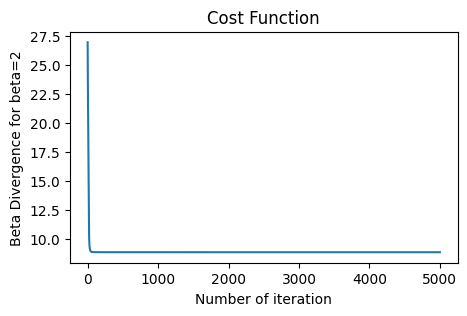

In [27]:
V = sound_stft_magnitude + 1e-10
beta=2
S= 3

# Applying the NMF Function
W, H, cost_function = NMF(V, S, beta=beta, threshold=0.05, MAXITER = 5000)

# PLot the cost function
plt.figure(figsize=(5,3))
plt.plot(cost_function)
plt.title('Cost Function')
plt.xlabel('Number of iteration')
plt.ylabel(f"Beta Divergence for beta={beta}")

## Filtering the different audio sources.

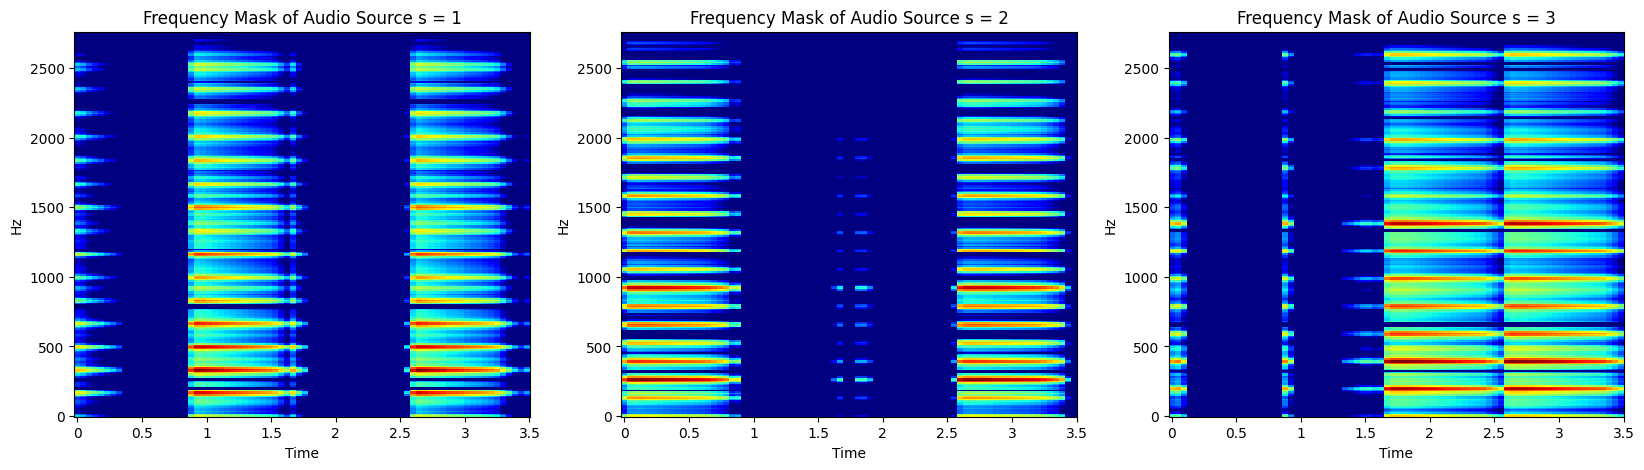

In [33]:
# After NMF, each audio source S can be expressed as a frequency mask over time.

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
filtered_spectrograms = []
for i in range(S):
  axs[i].set_title(f"Frequency Mask of Audio Source s = {i+1}")
  # Filter each source components
  filtered_spectrogram = W[:, [i]]@H[[i], :]
  # Compute the filtered spectrogram
  D = librosa.amplitude_to_db(filtered_spectrogram, ref=np.max)
  # Showed the filtered spectrogram
  librosa.display.specshow(D, y_axis='hz', sr=sr, hop_length=256, x_axis='time', cmap=matplotlib.cm.jet, ax=axs[i])

  filtered_spectrograms.append(filtered_spectrogram)


## Reconstructing source's audio signals.

In [30]:
reconstructed_sounds = []
for i in range(S):
  reconstruct = filtered_spectrograms[i] * np.exp(1j* sound_stft_angle)
  new_sound = librosa.istft(reconstruct, n_fft=512, hop_length=256)
  reconstructed_sounds.append(new_sound)

<ipython-input-31-5c5e7cc55f36>:5: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sounds[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')


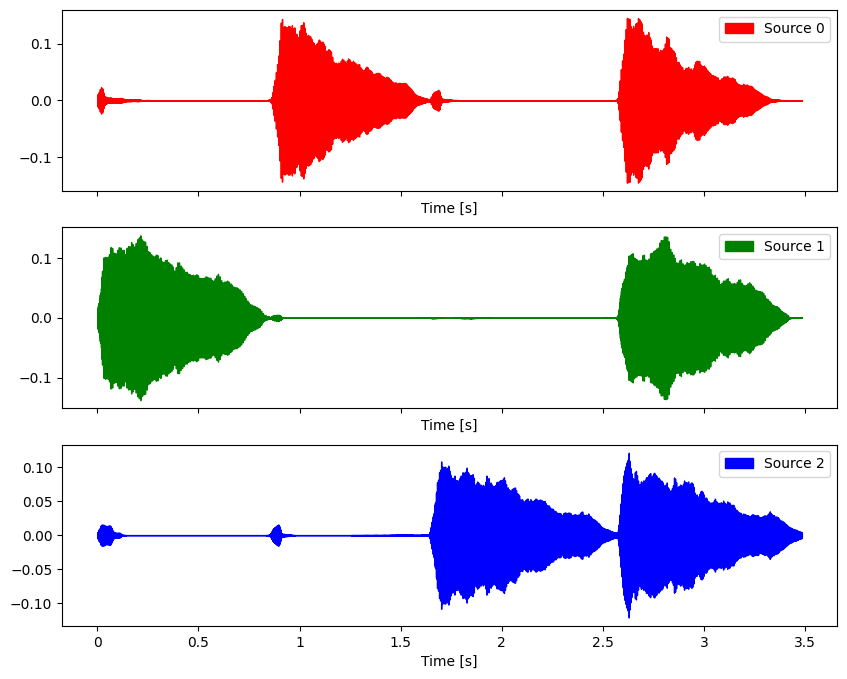

In [31]:
# Tracing the waveform
colors = ['r', 'g','b']
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
for i in range(S):
    librosa.display.waveshow(reconstructed_sounds[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')
    ax[i].set(xlabel='Time [s]')
    ax[i].legend()

## Challenges in NMF:
* Determining the number of sound sources.
* However, we can use iterative algorithm that starts with a small number of sound sources, and then increases the number of sound sources until the seperation is satisfactory.